<a href="https://colab.research.google.com/github/zulmarina1687/MCC-VA/blob/main/Lab2_TemplateMatching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
file_name = "fotogrupal"
file_name2 = "face"
path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/"

(1365, 2048, 3)


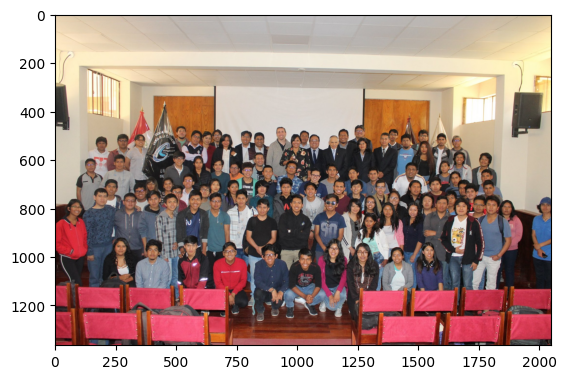

In [4]:
img = plt.imread(path+file_name+'.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

(56, 43, 4)


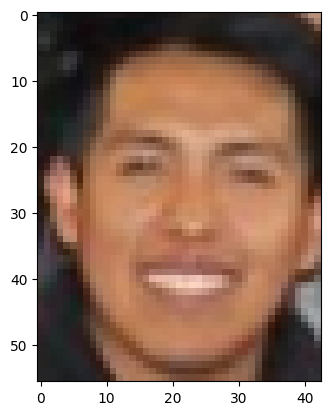

In [5]:
img = plt.imread(path+file_name2+'.jpg')
print(img.shape)
plt.imshow(img)
plt.show()

In [6]:
import os
import subprocess

In [7]:
!apt install libopencv-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libopencv-dev is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [8]:
!pip install nvcc4jupyter

In [9]:
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpq2c25y_k".


In [10]:
COMPILER_ARGS = subprocess.check_output(["pkg-config", "--cflags", "--libs", "opencv4"]).decode().strip()
print(COMPILER_ARGS)

-I/usr/include/opencv4 -lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core


In [11]:
%%cuda --compiler-args "$COMPILER_ARGS"

#include <iostream>
#include <stdio.h>
#include <opencv2/opencv.hpp>

using namespace cv;
using namespace std;

string file_name = "fotogrupal";
string face_filter = "face";
string path = "/content/drive/My Drive/Maestria/VA/Laboratorio1/";

string originalImage = path + file_name + ".jpg";
string faceFilter    = path + face_filter + ".jpg";
string output_file1  = path + file_name + "_gray_gpu.jpg";
string output_file2  = path + file_name + "_color_gpu.jpg";

float maxGlob =0;
float minGlob =0;


#define CHECK(call){const cudaError_t error = call;if (error != cudaSuccess){printf("Error: %s:%d, ", __FILE__, __LINE__);printf("code:%d, reason: %s\n", error, cudaGetErrorString(error));exit(1);}}


template <class T>
T* cuda_array(int n){
  T* arr;
  size_t tam = n * sizeof(T);
  CHECK(cudaMalloc(&arr, tam));
  return arr;
}

template <class T>
void cuda_H2D(T* h_arr, T* d_arr, int n){
  size_t tam = n * sizeof(T);
  CHECK(cudaMemcpy(d_arr, h_arr, tam, cudaMemcpyHostToDevice));
}


template <class T>
void cuda_D2H(T* d_arr, T* h_arr, int n){
  size_t tam = n * sizeof(T);
  CHECK(cudaMemcpy(h_arr, d_arr, tam, cudaMemcpyDeviceToHost));
}


__global__ void conv(unsigned char* d_data, float* d_kernel, int k, int p, int pos_k, int pos_p, int h, int w){
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  int j = blockIdx.y * blockDim.y + threadIdx.y;
  if(i < w && j < h){
    float sum = 0;
    for (size_t r = 0; r < k; r++) {
      for (size_t c = 0; c < p; c++) {
        sum += d_data[(j - pos_k + r) * w + (i - pos_p + c)] * d_kernel[r * p + c];
      }
    }
    d_data[j * w + i ] = sum;
  }
}


Mat aplicar_filtro(Mat& img_i, float* kernel, int k , int p, int i, int j){
  Mat img = img_i.clone();
  int h, w;
  h = img.size().height;
  w = img.size().width;


  float block_size = 16;
  dim3 block =  dim3(block_size, block_size, 1);
  dim3 grid =  dim3(ceil(w / block_size), ceil(h / block_size), 1);

  unsigned char* data = (unsigned char*)img.data;
  unsigned char* d_data = cuda_array<unsigned char>(h * w );
  float* d_kernel = cuda_array<float>(k * p);


  cuda_H2D(data, d_data, h * w );
  cuda_H2D(kernel, d_kernel, k * p);

  conv<<<grid, block>>>(d_data, d_kernel, k, p, i, j, h, w);

  cudaDeviceSynchronize();
  cuda_D2H(d_data, data, h * w );
  cudaFree(d_kernel);
  return img;

}

float normalize(float input,float minV, float maxV)
{
    return (input - minV) / (maxV - minV);
}

void templateMatchingInGray()
{
	cout<<"Using Gray Scale : "<<endl;
	Mat image, gray_image, 		//Original Image
		imgFilter,imgFilterGray;//Filter Image

	// Original Image
	image = imread( originalImage, 1 );
	resize(image, image,cv::Size(), 0.6, 0.6);

	cvtColor( image, gray_image, cv::COLOR_BGR2GRAY);
	//GaussianBlur(gray_image,gray_image,Size(5,5),10.0);
	//Canny( gray_image, gray_image, 50, 300, 3);


	//Filter Image
	imgFilter = imread( faceFilter, 1 );
	resize(imgFilter, imgFilter,cv::Size(), 0.6, 0.6);

	cvtColor( imgFilter, imgFilterGray, cv::COLOR_BGR2GRAY);
	GaussianBlur(imgFilterGray,imgFilterGray,Size(7,7),150.0);
	//Canny( imgFilterGray,imgFilterGray, 50, 300, 3);


	int wFilter =imgFilterGray.cols;
	int hFilter =imgFilterGray.rows;

	int w=image.cols;
	int h=image.rows;

	int wMiddlePointFilter=wFilter/2;
	int hMiddlePointFilter=hFilter/2;


	//Template matching Matrix
	Mat imgTM(h,w, CV_8UC1, Scalar(0));

	int filterScale=sqrt(wFilter*hFilter*255*255);

	cout<<"Buscando en la imagen"<<endl;
	for(int i=0+hMiddlePointFilter;i<(h-hMiddlePointFilter);i+=2)
	{
		for(int j=0+wMiddlePointFilter;j<w-wMiddlePointFilter;j+=2)
		{
			int factor=0;
			for(int x=0  ;x<hFilter;x++)
			{
				for(int y=0;y<wFilter;y++)
				{
					int pixelFilter	=imgFilterGray.at<uchar>(x, y);

					int _x = (i-hMiddlePointFilter)+x;
					int _y = (j-wMiddlePointFilter)+y;

					int pixel =gray_image.at<uchar>(_x, _y);

					factor+=pow(pixel-pixelFilter,2);
				}
			}
			float distance = normalize(sqrt(factor),0,filterScale);
			imgTM.at<uchar>(i,j) = 255-distance*255;
			if(distance < 0.15 )
			{
				//cout<<distance<<endl;
				Point point_1 = Point(j+wMiddlePointFilter,i+hMiddlePointFilter);
				Point point_2 = Point(j-wMiddlePointFilter,i-hMiddlePointFilter);

				rectangle(image,point_1,point_2,Scalar(0,0,255),1);
			}
		}
	}

	imwrite(output_file1.c_str(), image);
}


void templateMatchingInColor()
{
	cout<<"Using Colors in RGB"<<endl;
	Mat image, gray_image, 		//Original Image
		imgFilter,imgFilterGray;//Filter Image


	// Original Image
	image = imread(originalImage, 1 );
	resize(image, image,cv::Size(), 0.6, 0.6);


	//Filter Image
	imgFilter = imread(faceFilter, 1 );
	resize(imgFilter, imgFilter,cv::Size(), 0.6, 0.6);

	cvtColor(imgFilter, imgFilter,COLOR_BGR2RGB);
	GaussianBlur(imgFilter,imgFilter,Size(7,7),150.0);

	int wFilter =imgFilter.cols;
	int hFilter =imgFilter.rows;

	int w=image.cols;
	int h=image.rows;

	int wMiddlePointFilter=wFilter/2;
	int hMiddlePointFilter=hFilter/2;

	//Template matching Matrix
	Mat imgTM(h,w, CV_8UC1, Scalar(0));

	int filterScale=sqrt(wFilter*hFilter*255*255);

	cout<<"Buscando en la imagen"<<endl;
	for(int i=0+hMiddlePointFilter;i<(h-hMiddlePointFilter);i+=2)
	{

		for(int j=0+wMiddlePointFilter;j<w-wMiddlePointFilter;j+=2)
		{
			float factor=0;
			for(int x=0  ;x<hFilter;x++)
			{
				for(int y=0;y<wFilter;y++)
				{

					//Punto en el Filtro
					Vec3b pixelA =imgFilter.at<Vec3b>(x,y);
					//Punto en la imagen
					int _x = (i-hMiddlePointFilter)+x;
					int _y = (j-wMiddlePointFilter)+y;
					Vec3b pixelB =image.at<Vec3b>(_x, _y);

					//int pixVal_1 = normalize(int(pixelA[0]) *int(pixelA[1])*int(pixelA[2]),0,16581375)*255;
					//int pixVal_2 = normalize(int(pixelB[0]) *int(pixelB[1])*int(pixelB[2]),0,16581375)*255;
					int pixVal_1 = normalize(int(pixelA[0]) +int(pixelA[1])+int(pixelA[2]),0,765)*255;
					int pixVal_2 = normalize(int(pixelB[0]) +int(pixelB[1])+int(pixelB[2]),0,765)*255;

					factor+=pow(pixVal_1-pixVal_2,2);

				}
			}
			float distance = normalize(sqrt(factor),0,filterScale);
			imgTM.at<uchar>(i,j) = distance*255;

			if(distance < 0.14 )
			{

				Point point_1 = Point(j+wMiddlePointFilter,i+hMiddlePointFilter);
				Point point_2 = Point(j-wMiddlePointFilter,i-hMiddlePointFilter);
				rectangle(image,point_1,point_2,Scalar(0,0,255),1);

			}
		}
	}

	imwrite(output_file2.c_str(), image);
}

int main(void)
{
	templateMatchingInColor();
	templateMatchingInGray();

	return 0;
}

Using Colors in RGB
Buscando en la imagen
Using Gray Scale : 
Buscando en la imagen



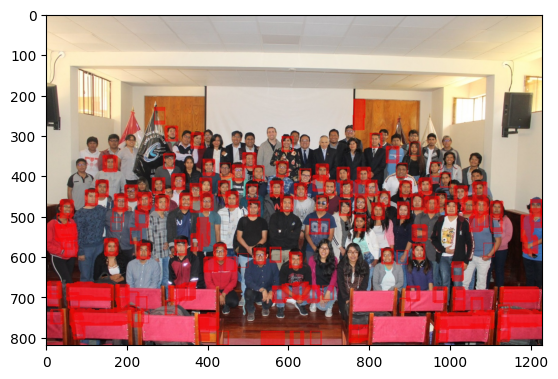

In [12]:
img = plt.imread(path+file_name+'_gray_gpu.jpg')
plt.imshow(img)
plt.show()

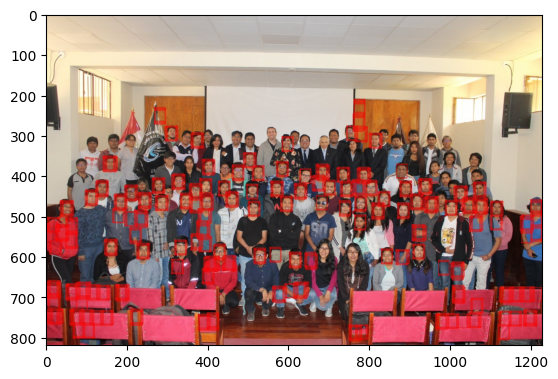

In [13]:
img = plt.imread(path+file_name+'_color_gpu.jpg')
plt.imshow(img)
plt.show()